## Prerequisite

Make sure you ran `snakemake` in this directory and have obtained all the files (stored under `output/`).

## Steps

This notebook will guide you through the following steps:

1. Load and merge individual model tables as written by `kipoi veff score_variants`
1. For each model output, compute the largest prediction decrease due to the variant
1. Select a single variant and plot the mutation-map

### Load original clinvar variants

In [1]:
import kipoi_veff

In [2]:
input_vcf = "input/clinvar_20180429.pathogenic.chr22.vcf.gz"

In [3]:
df_clinvar = pd.DataFrame(list(kipoi_veff.parsers.KipoiVCFParser(input_vcf)))

In [4]:
df_clinvar.head()

,variant_id,variant_chr,variant_pos,variant_ref,variant_alt,other_AF_ESP,other_AF_EXAC,other_AF_TGP,other_ALLELEID,other_CLNDN,other_CLNDNINCL,other_CLNDISDB,other_CLNDISDBINCL,other_CLNHGVS,other_CLNREVSTAT,other_CLNSIG,other_CLNSIGCONF,other_CLNSIGINCL,other_CLNVC,other_CLNVCSO,other_CLNVI,other_DBVARID,other_GENEINFO,other_MC,other_ORIGIN,other_RS,other_SSR
0,372206,chr22,17578719,C,T,NaN,NaN,NaN,359111,Immunodeficiency_51,None,"MedGen:C3151402,OMIM:...",None,NC_000022.10:g.175787...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,IL17RA:23765,SO:0001587|nonsense,1,1057518745,NaN
1,30486,chr22,17585619,C,T,NaN,NaN,NaN,39443,Immunodeficiency_51,None,"MedGen:C3151402,OMIM:...",None,NC_000022.10:g.175856...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,IL17RA:23765,SO:0001587|nonsense,1,387906913,NaN
2,372205,chr22,17589268,G,A,NaN,NaN,NaN,359110,Immunodeficiency_51,None,"MedGen:C3151402,OMIM:...",None,NC_000022.10:g.175892...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,IL17RA:23765,SO:0001583|missense_v...,1,1057519079,NaN
3,120299,chr22,17662794,T,C,0.0002,1.3000e-04,NaN,125893,"Polyarteritis_nodosa,...",None,"MedGen:C3887654,OMIM:...",None,NC_000022.10:g.176627...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,ADA2:51816,SO:0001583|missense_v...,1,376785840,NaN
4,189343,chr22,17663586,C,T,NaN,7.0000e-05,NaN,187232,Idiopathic_livedo_ret...,None,"MedGen:C0282492,OMIM:...",None,NC_000022.10:g.176635...,no_assertion_criteria...,Pathogenic,None,None,single_nucleotide_var...,SO:0001483,OMIM_Allelic_Variant:...,None,ADA2:51816,SO:0001583|missense_v...,1,770689762,NaN


## Load and visualize the predictions

In [5]:
ls -latr output/

total 20
drwxrwxr-x 3 avsec avsec 4096 Nov 12 23:19 DeepSEA/
drwxrwxr-x 3 avsec avsec 4096 Nov 12 23:19 DeepBind/
drwxrwxr-x 5 avsec avsec 4096 Nov 12 23:19 ./
drwxrwxr-x 2 avsec avsec 4096 Nov 12 23:20 Basset/
drwxrwxr-x 7 avsec avsec 4096 Nov 12 23:27 ../


In [6]:
import kipoi
import pandas as pd
import snakemake

# Get all models and interval_sets for which we computed the predictions
models, vcf_sets = list(zip(*list(zip(*snakemake.utils.listfiles("output/{model}/{interval_set}.tsv")))[1]))
models = kipoi.utils.unique_list(models)
vcf_sets = kipoi.utils.unique_list(vcf_sets)

In [7]:
vcf_sets = vcf_sets[:1]

### Loading predictions from the tsv output

In [8]:
import kipoi
import seaborn as sns
import pandas as pd

In [9]:
variant_cols = ['variant_chr', 'variant_pos', 'variant_ref', 'variant_alt']

In [10]:
merge_cols = variant_cols + ['variant_id', 'line_idx', 'vcf_set']

In [11]:
def read_preds_tsv(model, vcf_set, output_dir):
    df = pd.read_table("{}/{}/{}.tsv".format(output_dir, model, vcf_set))
    df['vcf_set'] = vcf_set
    df.set_index(merge_cols, inplace=True)
    assert df.columns.str.startswith("preds").all()
    
    df.columns = df.columns.str.replace("preds", model)
    #import ipdb
    #ipdb.set_trace()
    if len(df.columns) > 1:
        # multi-task model
        try:
            descr = kipoi.get_model_descr(model)
            df.columns = model + "/" + pd.Series(descr.schema.targets.column_labels)
        except:
            pass
    return df

In [12]:
df = pd.concat([pd.concat([read_preds_tsv(m, vcf_set=vcf_set, output_dir='output') for vcf_set in vcf_sets], axis=0) for m in models], axis=1)

In [13]:
df.head()

DeepSEA/variantEffects/8988T_DNase_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                              
chr22       17578719    C           T           372206     chr22:17578719:C:['T'] clinvar_20180429.patho...                   -0.0137                  
            17585619    C           T           30486      chr22:17585619:C:['T'] clinvar_20180429.patho...                   -0.1767                  
            17589268    G           A           372205     chr22:17589268:G:['A'] clinvar_20180429.patho...                    0.3075                  
            17662794    T           C           120299     chr22:17662794:T:['C'] clinvar_20180429.patho...                    0.1412                  
            17663586    C           T           189343     chr22:17663586:C:['T'] clinvar_20180429.patho...                    0.0602                  

                                                                                                             DeepSEA/variantEffects/AoSMC_DNase_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                              
chr22       17578719    C           T           372206     chr22:17578719:C:['T'] clinvar_20180429.patho...                    0.0787                  
            17585619    C           T           30486      chr22:17585619:C:['T'] clinvar_20180429.patho...                    0.0195                  
            17589268    G           A           372205     chr22:17589268:G:['A'] clinvar_20180429.patho...                    0.0632                  
            17662794    T           C           120299     chr22:17662794:T:['C'] clinvar_20180429.patho...                    0.0201                  
            17663586    C           T           189343     chr22:17663586:C:['T'] clinvar_20180429.patho...                   -0.0042                  

                                                                                                             DeepSEA/variantEffects/Chorion_DNase_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                                
chr22       17578719    C           T           372206     chr22:17578719:C:['T'] clinvar_20180429.patho...                    0.0261                    
            17585619    C           T           30486      chr22:17585619:C:['T'] clinvar_20180429.patho...                    0.0219                    
            17589268    G           A           372205     chr22:17589268:G:['A'] clinvar_20180429.patho...                    0.0467                    
            17662794    T           C           120299     chr22:17662794:T:['C'] clinvar_20180429.patho...                    0.0172                    
            17663586    C           T           189343     chr22:17663586:C:['T'] clinvar_20180429.patho...                   -0.0096                    

                                                                                                             DeepSEA/variantEffects/CLL_DNase_None  \
variant_chr variant_pos variant_ref variant_alt variant_id line_idx               vcf_set                                                            
chr22       17578719    C           T           372206     chr22:17578719:C:['T'] clinvar_20180429.patho...                    0.0092                
            17585619    C           T           30486      chr22:17585619:C:['T'] clinvar_20180429.patho...                   -0.0391                
            17589268    G           A           372205     chr22:17589268:G:['A'] clinvar_20180429.patho...                    0.1563                
            17662794    T           C           120299     chr22:17662794:T:['C'] clinvar_20180429.patho...                    0.0294                


In [14]:
df_clinvar[variant_cols + ['other_CLNSIG']]

,variant_chr,variant_pos,variant_ref,variant_alt,other_CLNSIG
0,chr22,17578719,C,T,Pathogenic
1,chr22,17585619,C,T,Pathogenic
2,chr22,17589268,G,A,Pathogenic
...,...,...,...,...,...
579,chr22,51158874,C,G,Pathogenic
580,chr22,51159610,C,T,Pathogenic
581,chr22,51159796,A,T,Pathogenic


### Append the clinical-siginifcance of variants

In [15]:
dfm = pd.merge(df.reset_index(), df_clinvar[variant_cols + ['other_CLNSIG']], on=variant_cols, how='left')
dfm.head()

,variant_chr,variant_pos,variant_ref,variant_alt,variant_id,line_idx,vcf_set,DeepSEA/variantEffects/8988T_DNase_None,DeepSEA/variantEffects/AoSMC_DNase_None,DeepSEA/variantEffects/Chorion_DNase_None,DeepSEA/variantEffects/CLL_DNase_None,DeepSEA/variantEffects/Fibrobl_DNase_None,DeepSEA/variantEffects/FibroP_DNase_None,DeepSEA/variantEffects/Gliobla_DNase_None,DeepSEA/variantEffects/GM12891_DNase_None,DeepSEA/variantEffects/GM12892_DNase_None,DeepSEA/variantEffects/GM18507_DNase_None,DeepSEA/variantEffects/GM19238_DNase_None,DeepSEA/variantEffects/GM19239_DNase_None,DeepSEA/variantEffects/GM19240_DNase_None,DeepSEA/variantEffects/H9ES_DNase_None,DeepSEA/variantEffects/HeLa-S3_DNase_IFNa4h,DeepSEA/variantEffects/Hepatocytes_DNase_None,DeepSEA/variantEffects/HPDE6-E6E7_DNase_None,DeepSEA/variantEffects/HSMM_emb_DNase_None,DeepSEA/variantEffects/HTR8svn_DNase_None,DeepSEA/variantEffects/Huh-7.5_DNase_None,DeepSEA/variantEffects/Huh-7_DNase_None,DeepSEA/variantEffects/iPS_DNase_None,DeepSEA/variantEffects/Ishikawa_DNase_Estradiol_100nM_1hr,DeepSEA/variantEffects/Ishikawa_DNase_4OHTAM_20nM_72hr,DeepSEA/variantEffects/LNCaP_DNase_androgen,DeepSEA/variantEffects/MCF-7_DNase_Hypoxia_LacAcid,DeepSEA/variantEffects/Medullo_DNase_None,DeepSEA/variantEffects/Melano_DNase_None,DeepSEA/variantEffects/Myometr_DNase_None,DeepSEA/variantEffects/Osteobl_DNase_None,DeepSEA/variantEffects/PanIsletD_DNase_None,DeepSEA/variantEffects/PanIslets_DNase_None,DeepSEA/variantEffects/pHTE_DNase_None,DeepSEA/variantEffects/ProgFib_DNase_None,DeepSEA/variantEffects/RWPE1_DNase_None,DeepSEA/variantEffects/Stellate_DNase_None,DeepSEA/variantEffects/T-47D_DNase_None,DeepSEA/variantEffects/Adult_CD4_Th0_DNase_None,DeepSEA/variantEffects/Urothelia_DNase_None,DeepSEA/variantEffects/Urothelia_DNase_UT189,DeepSEA/variantEffects/AG04449_DNase_None,DeepSEA/variantEffects/AG04450_DNase_None,DeepSEA/variantEffects/AG09309_DNase_None,DeepSEA/variantEffects/AG09319_DNase_None,DeepSEA/variantEffects/AG10803_DNase_None,DeepSEA/variantEffects/AoAF_DNase_None,DeepSEA/variantEffects/BE2_C_DNase_None,DeepSEA/variantEffects/BJ_DNase_None,DeepSEA/variantEffects/Caco-2_DNase_None,DeepSEA/variantEffects/CD20+_DNase_None,DeepSEA/variantEffects/CD34+_Mobilized_DNase_None,DeepSEA/variantEffects/CMK_DNase_None,DeepSEA/variantEffects/A549_DNase_None,DeepSEA/variantEffects/GM12878_DNase_None,DeepSEA/variantEffects/H1-hESC_DNase_None,DeepSEA/variantEffects/HeLa-S3_DNase_None,DeepSEA/variantEffects/HepG2_DNase_None,DeepSEA/variantEffects/HMEC_DNase_None,DeepSEA/variantEffects/HSMMtube_DNase_None,DeepSEA/variantEffects/HSMM_DNase_None,DeepSEA/variantEffects/HUVEC_DNase_None,DeepSEA/variantEffects/K562_DNase_None,DeepSEA/variantEffects/LNCaP_DNase_None,DeepSEA/variantEffects/MCF-7_DNase_None,DeepSEA/variantEffects/NHEK_DNase_None,DeepSEA/variantEffects/Th1_DNase_None,DeepSEA/variantEffects/GM06990_DNase_None,DeepSEA/variantEffects/GM12864_DNase_None,DeepSEA/variantEffects/GM12865_DNase_None,DeepSEA/variantEffects/H7-hESC_DNase_None,DeepSEA/variantEffects/HAc_DNase_None,DeepSEA/variantEffects/HAEpiC_DNase_None,DeepSEA/variantEffects/HA-h_DNase_None,DeepSEA/variantEffects/HA-sp_DNase_None,DeepSEA/variantEffects/HBMEC_DNase_None,DeepSEA/variantEffects/HCFaa_DNase_None,DeepSEA/variantEffects/HCF_DNase_None,DeepSEA/variantEffects/HCM_DNase_None,DeepSEA/variantEffects/HConF_DNase_None,DeepSEA/variantEffects/HCPEpiC_DNase_None,DeepSEA/variantEffects/HCT-116_DNase_None,DeepSEA/variantEffects/HEEpiC_DNase_None,DeepSEA/variantEffects/HFF-Myc_DNase_None,DeepSEA/variantEffects/HFF_DNase_None,DeepSEA/variantEffects/HGF_DNase_None,DeepSEA/variantEffects/HIPEpiC_DNase_None,DeepSEA/variantEffects/HL-60_DNase_None,DeepSEA/variantEffects/HMF_DNase_None,DeepSEA/variantEffects/HMVEC-dAd_DNase_None,DeepSEA/variantEffects/HMVEC-dBl-Ad_DNase_None,DeepSEA/variantEffects/HMVEC-dBl-Neo_DNase_None,DeepSEA/variantEffects/HMVEC-dLy-Ad_DNase_None,DeepSEA/variantEffects/HMVEC-dLy-Neo_DNase_None,DeepSEA/variantEffects/HMVE

### Get only the `diff` scores

In [16]:
dfm_sub = dfm[['vcf_set', 'other_CLNSIG'] + dfm.columns[dfm.columns.str.match('.*/.*')].tolist()]
dfm_sub

,vcf_set,other_CLNSIG,DeepSEA/variantEffects/8988T_DNase_None,DeepSEA/variantEffects/AoSMC_DNase_None,DeepSEA/variantEffects/Chorion_DNase_None,DeepSEA/variantEffects/CLL_DNase_None,DeepSEA/variantEffects/Fibrobl_DNase_None,DeepSEA/variantEffects/FibroP_DNase_None,DeepSEA/variantEffects/Gliobla_DNase_None,DeepSEA/variantEffects/GM12891_DNase_None,DeepSEA/variantEffects/GM12892_DNase_None,DeepSEA/variantEffects/GM18507_DNase_None,DeepSEA/variantEffects/GM19238_DNase_None,DeepSEA/variantEffects/GM19239_DNase_None,DeepSEA/variantEffects/GM19240_DNase_None,DeepSEA/variantEffects/H9ES_DNase_None,DeepSEA/variantEffects/HeLa-S3_DNase_IFNa4h,DeepSEA/variantEffects/Hepatocytes_DNase_None,DeepSEA/variantEffects/HPDE6-E6E7_DNase_None,DeepSEA/variantEffects/HSMM_emb_DNase_None,DeepSEA/variantEffects/HTR8svn_DNase_None,DeepSEA/variantEffects/Huh-7.5_DNase_None,DeepSEA/variantEffects/Huh-7_DNase_None,DeepSEA/variantEffects/iPS_DNase_None,DeepSEA/variantEffects/Ishikawa_DNase_Estradiol_100nM_1hr,DeepSEA/variantEffects/Ishikawa_DNase_4OHTAM_20nM_72hr,DeepSEA/variantEffects/LNCaP_DNase_androgen,DeepSEA/variantEffects/MCF-7_DNase_Hypoxia_LacAcid,DeepSEA/variantEffects/Medullo_DNase_None,DeepSEA/variantEffects/Melano_DNase_None,DeepSEA/variantEffects/Myometr_DNase_None,DeepSEA/variantEffects/Osteobl_DNase_None,DeepSEA/variantEffects/PanIsletD_DNase_None,DeepSEA/variantEffects/PanIslets_DNase_None,DeepSEA/variantEffects/pHTE_DNase_None,DeepSEA/variantEffects/ProgFib_DNase_None,DeepSEA/variantEffects/RWPE1_DNase_None,DeepSEA/variantEffects/Stellate_DNase_None,DeepSEA/variantEffects/T-47D_DNase_None,DeepSEA/variantEffects/Adult_CD4_Th0_DNase_None,DeepSEA/variantEffects/Urothelia_DNase_None,DeepSEA/variantEffects/Urothelia_DNase_UT189,DeepSEA/variantEffects/AG04449_DNase_None,DeepSEA/variantEffects/AG04450_DNase_None,DeepSEA/variantEffects/AG09309_DNase_None,DeepSEA/variantEffects/AG09319_DNase_None,DeepSEA/variantEffects/AG10803_DNase_None,DeepSEA/variantEffects/AoAF_DNase_None,DeepSEA/variantEffects/BE2_C_DNase_None,DeepSEA/variantEffects/BJ_DNase_None,DeepSEA/variantEffects/Caco-2_DNase_None,DeepSEA/variantEffects/CD20+_DNase_None,DeepSEA/variantEffects/CD34+_Mobilized_DNase_None,DeepSEA/variantEffects/CMK_DNase_None,DeepSEA/variantEffects/A549_DNase_None,DeepSEA/variantEffects/GM12878_DNase_None,DeepSEA/variantEffects/H1-hESC_DNase_None,DeepSEA/variantEffects/HeLa-S3_DNase_None,DeepSEA/variantEffects/HepG2_DNase_None,DeepSEA/variantEffects/HMEC_DNase_None,DeepSEA/variantEffects/HSMMtube_DNase_None,DeepSEA/variantEffects/HSMM_DNase_None,DeepSEA/variantEffects/HUVEC_DNase_None,DeepSEA/variantEffects/K562_DNase_None,DeepSEA/variantEffects/LNCaP_DNase_None,DeepSEA/variantEffects/MCF-7_DNase_None,DeepSEA/variantEffects/NHEK_DNase_None,DeepSEA/variantEffects/Th1_DNase_None,DeepSEA/variantEffects/GM06990_DNase_None,DeepSEA/variantEffects/GM12864_DNase_None,DeepSEA/variantEffects/GM12865_DNase_None,DeepSEA/variantEffects/H7-hESC_DNase_None,DeepSEA/variantEffects/HAc_DNase_None,DeepSEA/variantEffects/HAEpiC_DNase_None,DeepSEA/variantEffects/HA-h_DNase_None,DeepSEA/variantEffects/HA-sp_DNase_None,DeepSEA/variantEffects/HBMEC_DNase_None,DeepSEA/variantEffects/HCFaa_DNase_None,DeepSEA/variantEffects/HCF_DNase_None,DeepSEA/variantEffects/HCM_DNase_None,DeepSEA/variantEffects/HConF_DNase_None,DeepSEA/variantEffects/HCPEpiC_DNase_None,DeepSEA/variantEffects/HCT-116_DNase_None,DeepSEA/variantEffects/HEEpiC_DNase_None,DeepSEA/variantEffects/HFF-Myc_DNase_None,DeepSEA/variantEffects/HFF_DNase_None,DeepSEA/variantEffects/HGF_DNase_None,DeepSEA/variantEffects/HIPEpiC_DNase_None,DeepSEA/variantEffects/HL-60_DNase_None,DeepSEA/variantEffects/HMF_DNase_None,DeepSEA/variantEffects/HMVEC-dAd_DNase_None,DeepSEA/variantEffects/HMVEC-dBl-Ad_DNase_None,DeepSEA/variantEffects/HMVEC-dBl-Neo_DNase_None,DeepSEA/variantEffects/HMVEC-dLy-Ad_DNase_None,DeepSEA/variantEffects/HMVEC-dLy-Neo_DNase_None,DeepSEA/variantEffects/HMVEC-dNeo_DNase_None,DeepSEA/variantEffects/HMVEC-LBl_DNas

### Visualize the highest variant effect score per variant group per model

In [17]:
dfm_sub_max = dfm_sub[dfm_sub.other_CLNSIG.isin(["Pathogenic", 'Benign'])].groupby(['other_CLNSIG', 'vcf_set']).min().T

In [18]:
dfm_sub_max

other_CLNSIG,Pathogenic
vcf_set,clinvar_20180429.pathogenic.chr22
DeepSEA/variantEffects/8988T_DNase_None,-2.1025
DeepSEA/variantEffects/AoSMC_DNase_None,-1.2878
DeepSEA/variantEffects/Chorion_DNase_None,-0.7801
...,...
DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/diff/0,-10.1643
DeepBind/Homo_sapiens/TF/D00351.009_ChIP-seq_EGR1/diff/0,-2.3947
DeepBind/Homo_sapiens/TF/D00356.010_ChIP-seq_ELF1/diff/0,-2.3081


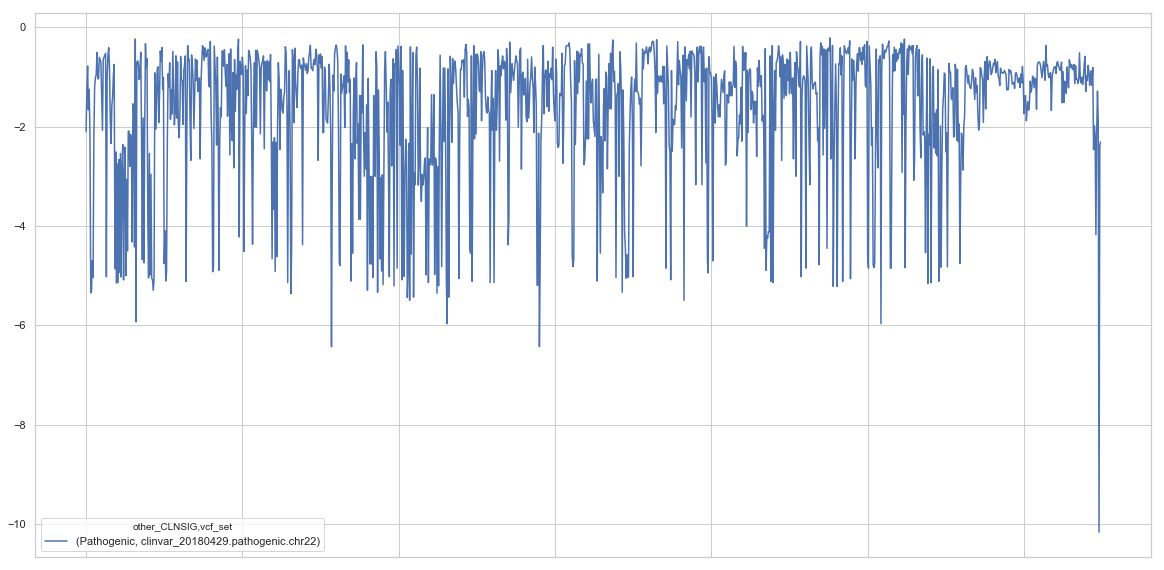

In [19]:
dfm_sub_max.plot(figsize=(20, 10))

In [20]:
# values with highest difference
dfm_sub_max.min(0)

other_CLNSIG  vcf_set                          
Pathogenic    clinvar_20180429.pathogenic.chr22   -10.1643
dtype: float64

In [21]:
dfm_sub_max.idxmin(0).values

array(['DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/diff/0'], dtype=object)

Which variant is this

In [22]:
idx = dfm[dfm.other_CLNSIG == 'Pathogenic']['DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/diff/0'].idxmin()

In [23]:
idx

477

In [24]:
dfm.loc[idx].variant_id

16664

In [25]:
print(df_clinvar[df_clinvar.variant_id == str(dfm.loc[idx].variant_id)].iloc[0].to_string())

variant_id                               16664
variant_chr                              chr22
variant_pos                           50964903
variant_ref                                  C
variant_alt                                  G
other_AF_ESP                               NaN
other_AF_EXAC                              NaN
other_AF_TGP                               NaN
other_ALLELEID                           31703
other_CLNDN           Mitochondrial_DNA_dep...
other_CLNDNINCL                           None
other_CLNDISDB        MedGen:C0872218,OMIM:...
other_CLNDISDBINCL                        None
other_CLNHGVS         NC_000022.10:g.509649...
other_CLNREVSTAT      no_assertion_criteria...
other_CLNSIG                        Pathogenic
other_CLNSIGCONF                          None
other_CLNSIGINCL                          None
other_CLNVC           single_nucleotide_var...
other_CLNVCSO                       SO:0001483
other_CLNVI           OMIM_Allelic_Variant:...
other_DBVARID

## Let's interpret the variant

In [26]:
# Let's look at only the top variant hits
!zcat {input_vcf} | grep -E '^#|{dfm.loc[idx].variant_id}' > '/tmp/variants_of_interest.vcf'

In [27]:
from kipoi_veff import MutationMap

In [28]:
m = kipoi.get_model("DeepBind/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF")

Using downloaded and verified file: /home/avsec/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/arch/0d6747991a525b94a1ac9174459c2bf4
Using downloaded and verified file: /home/avsec/.kipoi/models/DeepBind/downloaded/model_files/Homo_sapiens/TF/D00328.018_ChIP-seq_CTCF/weights/838eb7287139a2542f21984e692a9be2


Using TensorFlow backend.


In [29]:
mm = MutationMap(m, m.default_dataloader, dataloader_args={'fasta_file': '../1-predict/input/hg19.chr22.fa'})

In [30]:
mmplt = mm.query_vcf('/tmp/variants_of_interest.vcf')

  0%|          | 0/1 [00:00<?, ?it/s]
0it [00:00, ?it/s]
7it [00:00, 65.75it/s]
13it [00:00, 63.60it/s]
100%|██████████| 1/1 [00:00<00:00,  3.17it/s]


In [31]:
assert len(mmplt.mutation_map) == 1

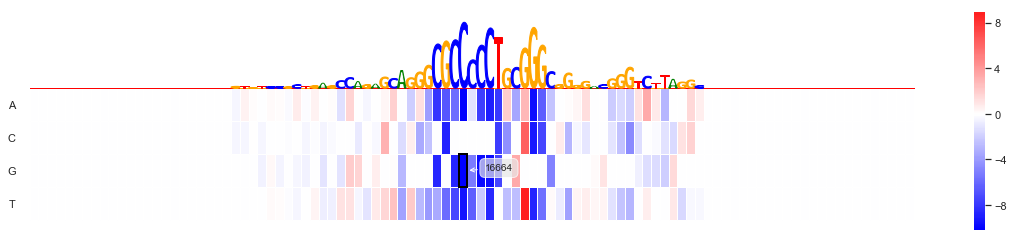

In [32]:
mmplt.plot_mutmap(0, 'seq', "diff", '0')

The variant of interest is indeed falling in the region of the CTCF motif.